# Credit Risk Resampling Techniques

In [34]:
import warnings
warnings.filterwarnings('ignore')

In [73]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import plot_confusion_matrix

# Read the CSV and Perform Basic Data Cleaning

In [36]:
columns = [
    "loan_amnt", "int_rate", "installment", "home_ownership",
    "annual_inc", "verification_status", "issue_d", "loan_status",
    "pymnt_plan", "dti", "delinq_2yrs", "inq_last_6mths",
    "open_acc", "pub_rec", "revol_bal", "total_acc",
    "initial_list_status", "out_prncp", "out_prncp_inv", "total_pymnt",
    "total_pymnt_inv", "total_rec_prncp", "total_rec_int", "total_rec_late_fee",
    "recoveries", "collection_recovery_fee", "last_pymnt_amnt", "next_pymnt_d",
    "collections_12_mths_ex_med", "policy_code", "application_type", "acc_now_delinq",
    "tot_coll_amt", "tot_cur_bal", "open_acc_6m", "open_act_il",
    "open_il_12m", "open_il_24m", "mths_since_rcnt_il", "total_bal_il",
    "il_util", "open_rv_12m", "open_rv_24m", "max_bal_bc",
    "all_util", "total_rev_hi_lim", "inq_fi", "total_cu_tl",
    "inq_last_12m", "acc_open_past_24mths", "avg_cur_bal", "bc_open_to_buy",
    "bc_util", "chargeoff_within_12_mths", "delinq_amnt", "mo_sin_old_il_acct",
    "mo_sin_old_rev_tl_op", "mo_sin_rcnt_rev_tl_op", "mo_sin_rcnt_tl", "mort_acc",
    "mths_since_recent_bc", "mths_since_recent_inq", "num_accts_ever_120_pd", "num_actv_bc_tl",
    "num_actv_rev_tl", "num_bc_sats", "num_bc_tl", "num_il_tl",
    "num_op_rev_tl", "num_rev_accts", "num_rev_tl_bal_gt_0",
    "num_sats", "num_tl_120dpd_2m", "num_tl_30dpd", "num_tl_90g_dpd_24m",
    "num_tl_op_past_12m", "pct_tl_nvr_dlq", "percent_bc_gt_75", "pub_rec_bankruptcies",
    "tax_liens", "tot_hi_cred_lim", "total_bal_ex_mort", "total_bc_limit",
    "total_il_high_credit_limit", "hardship_flag", "debt_settlement_flag"
]

target = ["loan_status"]

In [37]:
# Load the data
file_path = Path('LoanStats_2019Q1.csv')
df = pd.read_csv(file_path, skiprows=1)[:-2]
df = df.loc[:, columns].copy()

# Drop the null columns where all values are null
df = df.dropna(axis='columns', how='all')

# Drop the null rows
df = df.dropna()

# Remove the `Issued` loan status
issued_mask = df['loan_status'] != 'Issued'
df = df.loc[issued_mask]

# convert interest rate to numerical
df['int_rate'] = df['int_rate'].str.replace('%', '')
df['int_rate'] = df['int_rate'].astype('float') / 100


# Convert the target column values to low_risk and high_risk based on their values
x = {'Current': 'low_risk'}   
df = df.replace(x)

x = dict.fromkeys(['Late (31-120 days)', 'Late (16-30 days)', 'Default', 'In Grace Period'], 'high_risk')    
df = df.replace(x)

df.reset_index(inplace=True, drop=True)

df.head()
df.dtypes

loan_amnt                     float64
int_rate                      float64
installment                   float64
home_ownership                 object
annual_inc                    float64
                               ...   
total_bal_ex_mort             float64
total_bc_limit                float64
total_il_high_credit_limit    float64
hardship_flag                  object
debt_settlement_flag           object
Length: 86, dtype: object

In [38]:
# using get dumb 
df.select_dtypes(include='object')
pd.get_dummies(pd.DataFrame(df.select_dtypes(include='object')))

,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,issue_d_Feb-2019,issue_d_Jan-2019,issue_d_Mar-2019,...,loan_status_low_risk,pymnt_plan_n,initial_list_status_f,initial_list_status_w,next_pymnt_d_Apr-2019,next_pymnt_d_May-2019,application_type_Individual,application_type_Joint App,hardship_flag_N,debt_settlement_flag_N
0,0,0,0,1,0,1,0,0,0,1,...,1,1,0,1,0,1,1,0,1,1
1,0,1,0,0,0,0,1,0,0,1,...,1,1,0,1,0,1,1,0,1,1
2,0,1,0,0,0,0,1,0,0,1,...,1,1,0,1,0,1,1,0,1,1
3,0,0,0,1,0,0,1,0,0,1,...,1,1,0,1,0,1,1,0,1,1
4,0,1,0,0,1,0,0,0,0,1,...,1,1,0,1,0,1,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68812,0,0,0,1,0,1,0,0,1,0,...,1,1,0,1,0,1,1,0,1,1
68813,0,0,0,1,1,0,0,0,1,0,...,1,1,0,1,0,1,1,0,1,1
68814,0,1,0,0,0,1,0,0,1,0,...,1,1,0,1,0,1,1,0,1,1
68815,0,1,0,0,0,0,1,0,1,0,...,1,1,1,0,0,1,1,0,1,1


# Split the Data into Training and Testing

In [42]:
# Create our features
X = df.drop("loan_status", axis=1)

X = pd.get_dummies(X)
# Create our target
y = df['loan_status'] 
X

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,issue_d_Mar-2019,pymnt_plan_n,initial_list_status_f,initial_list_status_w,next_pymnt_d_Apr-2019,next_pymnt_d_May-2019,application_type_Individual,application_type_Joint App,hardship_flag_N,debt_settlement_flag_N
0,10500.0,0.1719,375.35,66000.0,27.24,0.0,0.0,8.0,0.0,1609.0,...,1,1,0,1,0,1,1,0,1,1
1,25000.0,0.2000,929.09,105000.0,20.23,0.0,0.0,17.0,1.0,18368.0,...,1,1,0,1,0,1,1,0,1,1
2,20000.0,0.2000,529.88,56000.0,24.26,0.0,0.0,8.0,0.0,13247.0,...,1,1,0,1,0,1,1,0,1,1
3,10000.0,0.1640,353.55,92000.0,31.44,0.0,1.0,10.0,1.0,17996.0,...,1,1,0,1,0,1,1,0,1,1
4,22000.0,0.1474,520.39,52000.0,18.76,0.0,1.0,14.0,0.0,9091.0,...,1,1,0,1,0,1,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68812,10000.0,0.1502,346.76,26000.0,9.60,0.0,0.0,9.0,0.0,2684.0,...,0,1,0,1,0,1,1,0,1,1
68813,12000.0,0.2727,368.37,63000.0,29.07,0.0,0.0,8.0,0.0,13314.0,...,0,1,0,1,0,1,1,0,1,1
68814,5000.0,0.1992,185.62,52000.0,14.86,0.0,0.0,5.0,1.0,3715.0,...,0,1,0,1,0,1,1,0,1,1
68815,40000.0,0.0646,1225.24,520000.0,9.96,0.0,1.0,21.0,0.0,59529.0,...,0,1,1,0,0,1,1,0,1,1


In [43]:
X.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,issue_d_Mar-2019,pymnt_plan_n,initial_list_status_f,initial_list_status_w,next_pymnt_d_Apr-2019,next_pymnt_d_May-2019,application_type_Individual,application_type_Joint App,hardship_flag_N,debt_settlement_flag_N
count,68817.000000,68817.000000,68817.000000,6.881700e+04,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,...,68817.000000,68817.0,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.0,68817.0
mean,16677.594562,0.127718,480.652863,8.821371e+04,21.778153,0.217766,0.497697,12.587340,0.126030,17604.142828,...,0.177238,1.0,0.123879,0.876121,0.383161,0.616839,0.860340,0.139660,1.0,1.0
std,10277.348590,0.048130,288.062432,1.155800e+05,20.199244,0.718367,0.758122,6.022869,0.336797,21835.880400,...,0.381873,0.0,0.329446,0.329446,0.486161,0.486161,0.346637,0.346637,0.0,0.0
min,1000.000000,0.060000,30.890000,4.000000e+01,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,...,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0
25%,9000.000000,0.088100,265.730000,5.000000e+04,13.890000,0.000000,0.000000,8.000000,0.000000,6293.000000,...,0.000000,1.0,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.0,1.0
50%,15000.000000,0.118000,404.560000,7.300000e+04,19.760000,0.000000,0.000000,11.000000,0.000000,12068.000000,...,0.000000,1.0,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.0,1.0
75%,24000.000000,0.155700,648.100000,1.040000e+05,26.660000,0.000000,1.000000,16.000000,0.000000,21735.000000,...,0.000000,1.0,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.0,1.0
max,40000.000000,0.308400,1676.230000,8.797500e+06,999.000000,18.000000,5.000000,72.000000,4.000000,587191.000000,...,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0


In [44]:
# Check the balance of our target values
y.value_counts()

low_risk     68470
high_risk      347
Name: loan_status, dtype: int64

In [45]:
from sklearn.model_selection import train_test_split
# YOUR CODE HERE
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
Counter(y_train)


Counter({'low_risk': 51366, 'high_risk': 246})

# Oversampling

In this section, you will compare two oversampling algorithms to determine which algorithm results in the best performance. You will oversample the data using the naive random oversampling algorithm and the SMOTE algorithm. For each algorithm, be sure to complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

### Naive Random Oversampling

In [46]:
# Resample the training data with the Naive Random
# YOUR CODE HERE
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
Counter(y_resampled)

Counter({'low_risk': 51366, 'high_risk': 51366})

In [47]:
# Train the Logistic Regression model using the resampled data
# YOUR CODE HERE
model = LogisticRegression(solver='lbfgs', random_state=1)
model.fit(X_resampled, y_resampled)


LogisticRegression(random_state=1)

In [48]:
# Calculated the balanced accuracy score
# YOUR CODE HERE
y_pred = model.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

0.6547385707934685

In [49]:
# Display the confusion matrix
# YOUR CODE HERE
cm = confusion_matrix(y_test, y_pred)
print(cm)


[[   73    28]
 [ 7069 10035]]


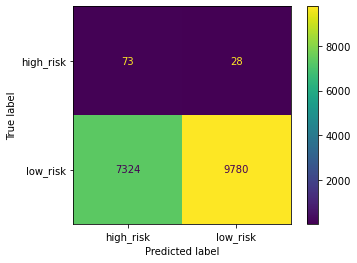

In [74]:
plot_confusion_matrix(model, X_test, y_test)

In [75]:
# Print the imbalanced classification report
# YOUR CODE HERE
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.01      0.72      0.57      0.02      0.64      0.42       101
   low_risk       1.00      0.57      0.72      0.73      0.64      0.41     17104

avg / total       0.99      0.57      0.72      0.72      0.64      0.41     17205



### SMOTE Oversampling

In [76]:
# Resample the training data with SMOTE
# YOUR CODE HERE
from imblearn.over_sampling import SMOTE
X_resampled, y_resampled = SMOTE(random_state=1,
sampling_strategy='auto').fit_resample(
   X_train, y_train)

In [77]:
# Train the Logistic Regression model using the resampled data
# YOUR CODE HERE
model = LogisticRegression(solver='lbfgs', random_state=1)
model.fit(X_resampled, y_resampled)

LogisticRegression(random_state=1)

In [78]:
# Calculated the balanced accuracy score
# YOUR CODE HERE
y_pred = model.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

0.66201409663885

In [79]:
# Display the confusion matrix
# YOUR CODE HERE
confusion_matrix(y_test, y_pred)


array([[   64,    37],
       [ 5296, 11808]])

In [80]:
# Print the imbalanced classification report
# YOUR CODE HERE
print(classification_report_imbalanced(y_test, y_pred))


                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.01      0.63      0.69      0.02      0.66      0.43       101
   low_risk       1.00      0.69      0.63      0.82      0.66      0.44     17104

avg / total       0.99      0.69      0.63      0.81      0.66      0.44     17205



# Undersampling

In this section, you will test an undersampling algorithms to determine which algorithm results in the best performance compared to the oversampling algorithms above. You will undersample the data using the Cluster Centroids algorithm and complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

In [81]:
# Resample the data using the ClusterCentroids resampler
# Warning: This is a large dataset, and this step may take some time to complete
# YOUR CODE HERE
from imblearn.under_sampling import ClusterCentroids
cc = ClusterCentroids(random_state=1)
X_resampled, y_resampled = cc.fit_resample(X_train, y_train)

In [82]:
# Train the Logistic Regression model using the resampled data
# YOUR CODE HERE
model = LogisticRegression(solver='lbfgs', random_state=1)
model.fit(X_resampled, y_resampled)

LogisticRegression(random_state=1)

In [83]:
# Calculated the balanced accuracy score
# YOUR CODE HERE
balanced_accuracy_score(y_test, y_pred)


0.66201409663885

In [84]:
# Display the confusion matrix
# YOUR CODE HERE
y_pred = model.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[   70,    31],
       [10341,  6763]])

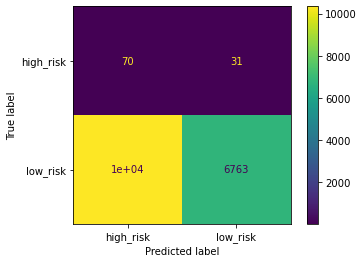

In [86]:
plot_confusion_matrix(model, X_test, y_test)

In [87]:
# Print the imbalanced classification report
# YOUR CODE HERE
print(classification_report_imbalanced(y_test, y_pred))


                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.01      0.69      0.40      0.01      0.52      0.28       101
   low_risk       1.00      0.40      0.69      0.57      0.52      0.27     17104

avg / total       0.99      0.40      0.69      0.56      0.52      0.27     17205



# Combination (Over and Under) Sampling

In this section, you will test a combination over- and under-sampling algorithm to determine if the algorithm results in the best performance compared to the other sampling algorithms above. You will resample the data using the SMOTEENN algorithm and complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

In [88]:
# Resample the training data with SMOTEENN
# Warning: This is a large dataset, and this step may take some time to complete
# YOUR CODE HERE
from imblearn.combine import SMOTEENN
smote_enn = SMOTEENN(random_state=0)
X_resampled, y_resampled = smote_enn.fit_resample(X, y)

In [89]:
# Train the Logistic Regression model using the resampled data
# YOUR CODE HERE
model = LogisticRegression(solver='lbfgs', random_state=1)
model.fit(X_resampled, y_resampled)

LogisticRegression(random_state=1)

In [90]:
# Calculated the balanced accuracy score
# YOUR CODE HERE
balanced_accuracy_score(y_test, y_pred)


0.5442369453268994

In [91]:
# Display the confusion matrix
# YOUR CODE HERE
y_pred = model.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[  73,   28],
       [7324, 9780]])

In [92]:
# Print the imbalanced classification report
# YOUR CODE HERE
print(classification_report_imbalanced(y_test, y_pred))


                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.01      0.72      0.57      0.02      0.64      0.42       101
   low_risk       1.00      0.57      0.72      0.73      0.64      0.41     17104

avg / total       0.99      0.57      0.72      0.72      0.64      0.41     17205



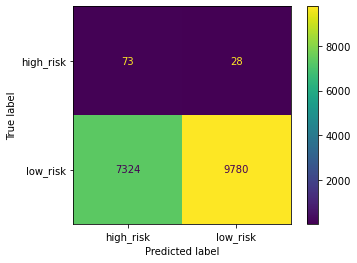

In [93]:
plot_confusion_matrix(model, X_test, y_test)